In [45]:
import json
import os
import pickle
import psycopg2
import pandas as pd
import sqlalchemy
import sys
sys.path.append("..")

from connect_db import db_connection


import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import matplotlib.cm as cm
import seaborn as sns
get_ipython().magic(u'matplotlib inline')
%matplotlib inline

username='ywang99587'




from scipy.spatial import distance
import scipy.spatial.distance
from scipy.spatial.distance import cdist, pdist
import pylab as pl

In [46]:
cred_location = '../connect_db/data_creds_redshift.json.nogit'  ## changed to TPT
db = db_connection.DBConnection(cred_location)

In [47]:
airport_fl = pd.read_csv('/mnt/data/shared/airport_Florence.csv')
airport_fl.head()

,Giorno,Ora Effettiva,Nazione,Pax Totali
0,01/05/2017,07:57,Spain,88
1,01/05/2017,08:07,Russian Federation,4
2,01/05/2017,09:00,France,94
3,01/05/2017,09:28,Germany,48
4,01/05/2017,10:44,Netherlands,91


In [48]:
airport_fl['Giorno'] = pd.to_datetime(airport_fl['Giorno'], dayfirst=True)

In [49]:
airport_fl['year'], airport_fl['month'] = airport_fl['Giorno'].dt.year, airport_fl['Giorno'].dt.month

In [50]:
airport_fl = airport_fl.rename(columns={"Pax Totali":"Total", "Nazione":"Country"})
airport_fl.tail()

,Giorno,Ora Effettiva,Country,Total,year,month
13531,2018-02-28,19:53,Romania,106,2018,2
13532,2018-02-28,20:47,Germany,77,2018,2
13533,2018-02-28,22:38,Italy,136,2018,2
13534,2018-02-28,22:51,Germany,105,2018,2
13535,2018-02-28,23:00,Netherlands,86,2018,2


In [51]:
airport_fl = airport_fl.replace({'month':{1:'January', 2:'February',5:'May',6:'June',7:'July',8:'August',9:'September',
                            10:'October',11:'November',12:'December'}})

In [52]:
airport_fl[airport_fl['Country']=='-']

,Giorno,Ora Effettiva,Country,Total,year,month
4396,2017-07-20,21:25,-,5,2017,July
5672,2017-08-14,16:31,-,2,2017,August
6077,2017-08-22,18:53,-,5,2017,August
9557,2017-10-28,13:11,-,8,2017,October
10021,2017-11-10,13:30,-,1,2017,November


In [53]:
fl_by_mon = pd.DataFrame(airport_fl.groupby(['month','Country'])["Total"].sum())  #.reset_index()

In [54]:
fl_by_mon = fl_by_mon.sort_values(['month','Total'], ascending=[True, False])
fl_by_mon.head(15)

Total
month  Country                    
August Germany               24205
       France                24147
       Italy                 18658
       Spain                 14955
       Netherlands           13558
       United Kingdom        13389
       Switzerland            7681
       Belgium                3982
       Romania                3198
       Greece                 2312
       Albania                2145
       Austria                2032
       Denmark                1044
       Moldova, Republic of   1032
       Israel                  526

In [55]:
fl_by_mon_top = fl_by_mon.sort_values(['month','Total'], ascending=[True, False]).groupby('month').head(8)
#fl_by_mon_top

In [56]:
top7_countries = ['Germany', 'France','United Kingdom','Netherlands','Spain','Switzerland','Italy']

In [57]:
def top_or_other(row):
    if row['Country'] in top7_countries:
        return row['Country']
    else:
        return 'Other'

In [58]:
#fl_de = fl_by_mon.loc[10]

In [59]:
fl_by_mon_col = fl_by_mon.reset_index(level=['Country','month'])
fl_by_mon_col.head()

,month,Country,Total
0,August,Germany,24205
1,August,France,24147
2,August,Italy,18658
3,August,Spain,14955
4,August,Netherlands,13558


In [60]:
fl_by_mon_col['Country_ot'] = fl_by_mon_col.apply(top_or_other,1)
fl_by_mon_col.head(10)

,month,Country,Total,Country_ot
0,August,Germany,24205,Germany
1,August,France,24147,France
2,August,Italy,18658,Italy
3,August,Spain,14955,Spain
4,August,Netherlands,13558,Netherlands
5,August,United Kingdom,13389,United Kingdom
6,August,Switzerland,7681,Switzerland
7,August,Belgium,3982,Other
8,August,Romania,3198,Other
9,August,Greece,2312,Other


In [61]:
## aggregate "Other"
fl_by_mon_col_agg = pd.DataFrame(fl_by_mon_col.groupby(['month','Country_ot'])["Total"].sum().reset_index())

In [62]:
fl_ger=fl_by_mon_col_agg[fl_by_mon_col_agg['Country_ot']=="Germany"][['month', 'Total']].rename(columns={'Total':'Floraace'})

In [63]:
fl_by_mon_col_pvt = fl_by_mon_col_agg.pivot(index='month', columns='Country_ot', values='Total')

In [64]:
fl_by_mon_col_pvt

Country_ot,France,Germany,Italy,Netherlands,Other,Spain,Switzerland,United Kingdom
month,,,,,,,,
August,24147,24205,18658,13558,16716,14955,7681,13389
December,18876,13864,11549,6417,4885,8640,6275,7157
February,15715,16025,12555,6999,2857,8302,5909,5960
January,19459,16808,14823,7116,5746,9357,6349,6289
July,27033,26900,17457,14733,15422,14376,7922,12494
June,26895,29741,18911,13737,12821,13125,8024,10968
May,28865,29744,16073,14145,10197,12048,7504,10408
November,17899,15948,14633,6559,5273,8503,6508,6760
October,26090,25723,17622,12754,12304,12278,7503,9324


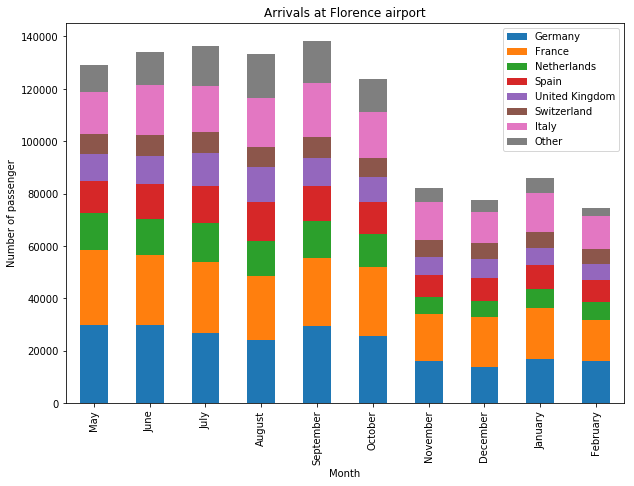

In [65]:
fl_by_mon_col_pvt.loc[['May','June','July','August','September','October','November','December','January', 'February'],
                      ['Germany', 'France','Netherlands','Spain','United Kingdom','Switzerland','Italy', 'Other']].plot.bar(stacked=True,  figsize=(10,7))
plt.title('Arrivals at Florence airport')  
plt.xlabel('Month')  
plt.ylabel('Number of passenger')  
plt.legend()

In [66]:
### same for pisa

In [67]:
airport_ps = pd.read_csv('/mnt/data/shared/airport_Pisa.csv')
airport_ps.head()

,Giorno,Ora Effettiva,Nazione,Pax Totali
0,01/05/2017,07:10,Switzerland,90
1,01/05/2017,07:51,Italy,186
2,01/05/2017,08:10,Italy,175
3,01/05/2017,08:30,Albania,129
4,01/05/2017,08:35,Netherlands,165


In [68]:
airport_ps['Giorno'] = pd.to_datetime(airport_ps['Giorno'], dayfirst=True)

In [69]:
airport_ps['year'], airport_ps['month'] = airport_ps['Giorno'].dt.year, airport_ps['Giorno'].dt.month


In [70]:
airport_ps = airport_ps.rename(columns={"Pax Totali":"Total", "Nazione":"Country"})
airport_ps.tail()

,Giorno,Ora Effettiva,Country,Total,year,month
16311,2018-02-28,20:35,Malta,0,2018,2
16312,2018-02-28,21:41,Italy,170,2018,2
16313,2018-02-28,22:36,Italy,63,2018,2
16314,2018-02-28,22:59,Italy,137,2018,2
16315,2018-02-28,23:04,Italy,128,2018,2


In [71]:
airport_ps = airport_ps.replace({'month':{1:'January', 2:'February',5:'May',6:'June',7:'July',8:'August',9:'September',
                            10:'October',11:'November',12:'December'}})

In [72]:
ps_by_mon = pd.DataFrame(airport_ps.groupby(['month','Country'])["Total"].sum().reset_index())  #.reset_index()

In [73]:
ps_by_mon = ps_by_mon.sort_values(['month','Total'], ascending=[True, False])
ps_by_mon.head(15)

,month,Country,Total
41,August,United Kingdom,72143
19,August,Italy,66817
35,August,Spain,32847
14,August,Germany,19337
25,August,Netherlands,16054
12,August,France,14496
15,August,Greece,9357
4,August,Belgium,7894
1,August,Albania,6923
36,August,Sweden,5964


In [74]:
ps_by_mon_top = ps_by_mon.sort_values(['month','Total'], ascending=[True, False]).groupby('month').head(7)
#ps_by_mon_top

In [75]:
def top_or_other_ps(row):
    if row['Country'] in list(ps_by_mon_top.Country[ps_by_mon_top['month']==row['month']]):
        return row['Country']
    else:
        return 'Other'

In [76]:
ps_by_mon['Country_ot'] = ps_by_mon.apply(top_or_other_ps,1)
ps_by_mon.head(10)

,month,Country,Total,Country_ot
41,August,United Kingdom,72143,United Kingdom
19,August,Italy,66817,Italy
35,August,Spain,32847,Spain
14,August,Germany,19337,Germany
25,August,Netherlands,16054,Netherlands
12,August,France,14496,France
15,August,Greece,9357,Greece
4,August,Belgium,7894,Other
1,August,Albania,6923,Other
36,August,Sweden,5964,Other


In [77]:
## aggregate "Other"
ps_by_mon_agg = pd.DataFrame(ps_by_mon.groupby(['month','Country_ot'])["Total"].sum().reset_index())

In [78]:
ps_by_mon_pvt = ps_by_mon_agg.pivot(index='month', columns='Country_ot', values='Total')

In [113]:
ps_by_mon_pvt['Germany']

month
August       19337.0
December      9572.0
February      9169.0
January       8062.0
July         21229.0
June         21093.0
May          19934.0
November      8563.0
October      18419.0
September    21919.0
Name: Germany, dtype: float64

In [80]:
ps_by_mon_pvt = ps_by_mon_pvt.fillna(value=0)

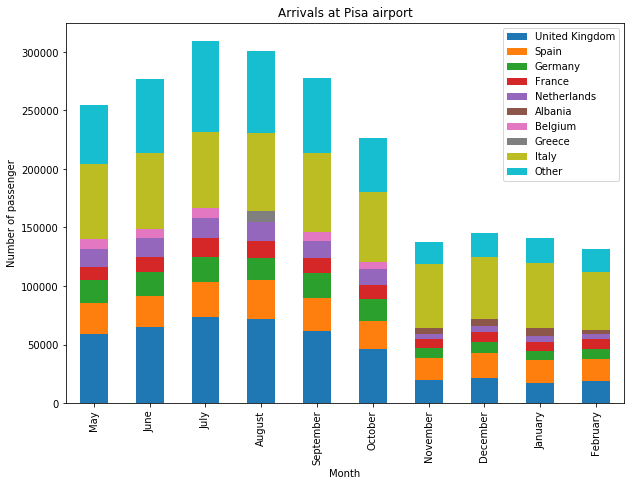

In [81]:
ps_by_mon_pvt.loc[['May','June','July','August','September','October','November','December','January', 'February'],
                  ['United Kingdom','Spain','Germany', 'France','Netherlands','Albania','Belgium','Greece','Italy', 'Other']].plot.bar(stacked=True,  figsize=(10,7))
plt.title('Arrivals at Pisa airport')  
plt.xlabel('Month')  
plt.ylabel('Number of passenger')  
plt.legend()

In [82]:
## Vodafone start time by month

In [83]:
q_mon_mcc = """select distinct mcc, mon_arvl_tusc, count(*) over (partition by mcc, mon_arvl_tusc) as total
from tpt.tuscany.customer_feature
where customer_id not in (select customer_id from tuscany.excluded_customers)
order by mcc"""

In [84]:
vf_mon_mcc = db.sql_query_to_data_frame(q_mon_mcc, cust_id=True)
vf_mon_mcc.dtypes

mcc              object
mon_arvl_tusc    object
total             int64
dtype: object

In [85]:
vf_mon_mcc['mcc'] = vf_mon_mcc['mcc'].astype(int)

In [86]:
mcc_region=pd.read_csv('/mnt/data/shared/mcc_country_region.csv')


In [87]:
mcc_country_region=mcc_region.drop_duplicates("MCC", keep='first')[['MCC', 'Country','Region']]

In [88]:
mcc_country_region['mcc']=mcc_country_region['MCC'].astype(int)

In [89]:
def clean_guam(row):
    if row['Country']=='Guam':
        return 'United States'
    else:
        return row['Country']

In [90]:
mcc_country_region['Country']=mcc_country_region.apply(clean_guam,1)
mcc_country_region.head()

,MCC,Country,Region,mcc
0,289,Abkhazia,Unknown,289
3,412,Afghanistan,ASIA (EX. NEAR EAST),412
11,276,Albania,EASTERN EUROPE,276
15,603,Algeria,NORTHERN AFRICA,603
18,544,American Samoa,OCEANIA,544


In [91]:
mcc_country_region.MCC[mcc_country_region['Country']=='Germany']

418    262
Name: MCC, dtype: int64

In [92]:
vf_mon_mcc = pd.merge(vf_mon_mcc, mcc_country_region[['mcc','Country','Region']], on=['mcc', 'mcc'])

In [93]:
vf_mon_mcc.head()

,mcc,mon_arvl_tusc,total,Country,Region
0,202,7,3129,Greece,WESTERN EUROPE
1,202,8,4084,Greece,WESTERN EUROPE
2,202,6,2784,Greece,WESTERN EUROPE
3,202,10,3186,Greece,WESTERN EUROPE
4,202,2,1845,Greece,WESTERN EUROPE


In [94]:
vf_mon_mcc = vf_mon_mcc.rename(columns={"mon_arvl_tusc":"month","total":"Total"})

In [95]:
vf_mon_mcc = vf_mon_mcc.replace({'month':{1:'January', 2:'February',5:'May',6:'June',7:'July',8:'August',9:'September',
                            10:'October',11:'November',12:'December'}})

In [96]:
## top countries are different
vf_top = vf_mon_mcc.sort_values(['month','Total'], ascending=[True, False]).groupby('month').head(7)


In [97]:
#vf_top

In [98]:
def top_or_other_vf(row):
    if row['Country'] in list(vf_top.Country[vf_top['month']==row['month']]):
        return row['Country']
    else:
        return 'Other'

In [99]:
vf_mon_mcc['Country_ot'] = vf_mon_mcc.apply(top_or_other_vf, 1)

In [100]:
vf_mon_mcc.head(10)

,mcc,month,Total,Country,Region,Country_ot
0,202,July,3129,Greece,WESTERN EUROPE,Other
1,202,August,4084,Greece,WESTERN EUROPE,Other
2,202,June,2784,Greece,WESTERN EUROPE,Other
3,202,October,3186,Greece,WESTERN EUROPE,Other
4,202,February,1845,Greece,WESTERN EUROPE,Other
5,202,May,2141,Greece,WESTERN EUROPE,Other
6,202,December,3057,Greece,WESTERN EUROPE,Other
7,202,September,2266,Greece,WESTERN EUROPE,Other
8,202,November,2436,Greece,WESTERN EUROPE,Other
9,202,January,1798,Greece,WESTERN EUROPE,Other


In [101]:
vf_mon_mcc_agg = pd.DataFrame(vf_mon_mcc.groupby(['month','Country_ot'])["Total"].sum().reset_index())

In [102]:
vf_mon_mcc_agg.head(10)

,month,Country_ot,Total
0,August,China,43096
1,August,France,155935
2,August,Germany,183189
3,August,Netherlands,90565
4,August,Other,337441
5,August,Spain,57338
6,August,United Kingdom,101744
7,August,United States,57403
8,December,China,18304
9,December,France,31832


In [103]:
vf_mon_pvt =  vf_mon_mcc_agg.pivot(index='month', columns='Country_ot', values='Total')

In [104]:
vf_mon_pvt

Country_ot,Belgium,China,France,Germany,Netherlands,Other,Spain,Switzerland,United Kingdom,United States
month,,,,,,,,,,
August,NaN,43096.0,155935.0,183189.0,90565.0,337441.0,57338.0,NaN,101744.0,57403.0
December,NaN,18304.0,31832.0,20874.0,22229.0,110054.0,19889.0,NaN,16566.0,27447.0
February,NaN,30926.0,29285.0,17971.0,36884.0,94865.0,17415.0,NaN,18183.0,23146.0
January,NaN,16124.0,21487.0,15468.0,20613.0,98234.0,15437.0,NaN,13404.0,25340.0
July,58949.0,NaN,100864.0,143039.0,102130.0,459333.0,NaN,68404.0,90212.0,78319.0
June,NaN,35168.0,47439.0,156232.0,50963.0,355358.0,NaN,NaN,76781.0,119507.0
May,NaN,37303.0,64249.0,91034.0,49212.0,284919.0,NaN,36765.0,65661.0,97024.0
November,NaN,25811.0,24610.0,21484.0,20307.0,111578.0,17523.0,NaN,17957.0,40277.0
October,NaN,38516.0,49027.0,79054.0,38403.0,275098.0,NaN,NaN,47805.0,86238.0


In [105]:
vf_mon_pvt = vf_mon_pvt.fillna(value=0)

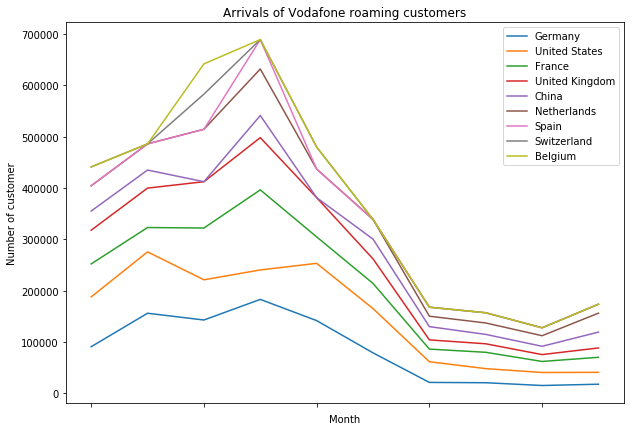

In [117]:
vf_mon_pvt.loc[['May','June','July','August','September','October','November','December','January', 'February'],
               ['Germany','United States', 'France','United Kingdom','China','Netherlands','Spain','Switzerland','Belgium']].plot.line(stacked=True,  figsize=(10,7))
plt.title('Arrivals of Vodafone roaming customers')  
plt.xlabel('Month')  
plt.ylabel('Number of customer')  
plt.legend()

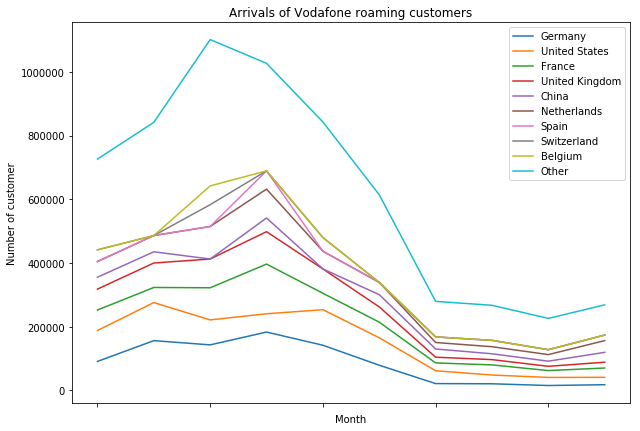

In [107]:
vf_mon_pvt.loc[['May','June','July','August','September','October','November','December','January', 'February'],
               ['Germany','United States', 'France','United Kingdom','China','Netherlands','Spain','Switzerland','Belgium','Other']].plot.line(stacked=True,  figsize=(10,7))
plt.title('Arrivals of Vodafone roaming customers')  
plt.xlabel('Month')  
plt.ylabel('Number of customer')  
plt.legend()

In [120]:
germans=vf_mon_pvt.loc[['May','June','July','August','September','October','November','December','January', 'February'],
               ['Germany']].rename(columns={'Germany':'Vodafone'}).join(fl_ger.set_index('month')).join(ps_by_mon_pvt[['Germany']].rename(columns={'Germany':'Pisa'}))

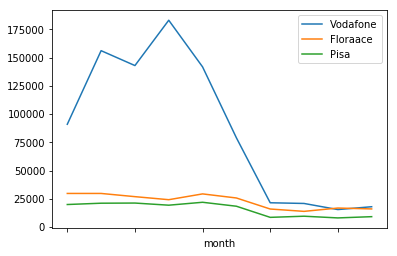

In [121]:
germans.plot()

In [122]:
query3="""with get_germans as (
select * from tuscany.vodafone 
where mcc = '262'
and customer_id not in (select customer_id from tuscany.excluded_customers)
),

first_arrival as (
select customer_id,
first_value(location_id) over (partition by customer_id order by time_stamp asc rows between unbounded preceding and unbounded following) as first_location_id,
extract (month from first_value(time_stamp) over (partition by customer_id order by time_stamp asc rows between unbounded preceding and unbounded following)) as first_month
from get_germans
)

select 
first_month,
sum(loc.firenze) as firenze_sum,
sum(loc.pisa) as pisa_sum
from first_arrival as f
left join tuscany.location_features as loc
on loc.location_id= f.first_location_id
group by first_month"""

In [123]:
username='ovasarhelyi'
cred_location = '/mnt/data/'+username+'/TPT_tourism/connect_db/data_creds_redshift.json.nogit'
db = db_connection.DBConnection(cred_location)

In [124]:
vodafone_airports = db.sql_query_to_data_frame(query3, cust_id=False)

In [136]:
vodafone_airports['firenze_sum']=vodafone_airports['firenze_sum'].astype(float)
vodafone_airports['pisa_sum']=vodafone_airports['pisa_sum'].astype(float)

In [131]:
vodafone_airports = vodafone_airports.replace({'first_month':{1:'January', 2:'February',5:'May',6:'June',7:'July',8:'August',9:'September',
                            10:'October',11:'November',12:'December'}})

In [140]:
g=germans.join(vodafone_airports.set_index('first_month'))

In [149]:
g=g.rename(columns={"Floraace":"Florence Airport",
         "Pisa": "Pisa Airport",
         "firenze_sum":"First data point in Florence (Vodafone)",
          "pisa_sum": "First data point in Pisa (Vodafone)"})

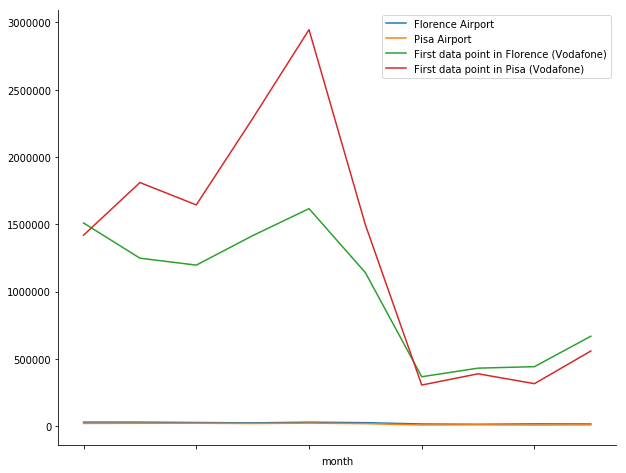

In [156]:
g[g.columns[1:]].plot(figsize=(10,8))
sns.despine()